# This notebook goes with Lesson 8, section 9 of the Tenorflow 2.0 course on Udacity. It is about forecasting using moving averages.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

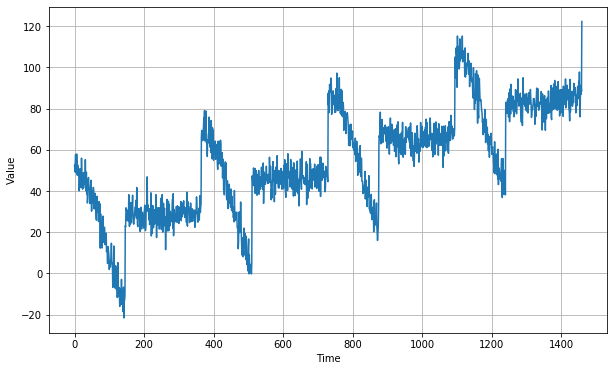

In [6]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

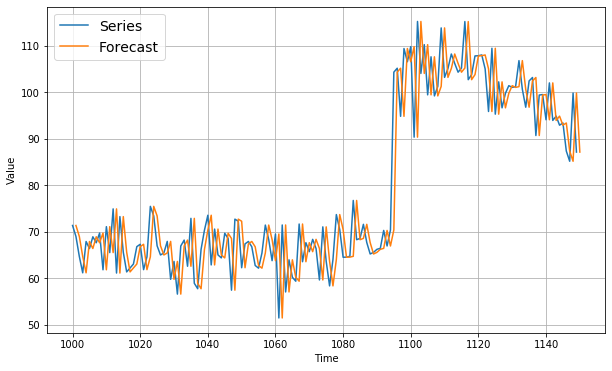

In [7]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [10]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.937908515321673

## Moving Average

In [11]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time+window_size].mean())
    return np.array(forecast)

In [14]:
# does the same thing as the last one, but MUCH faster
def moving_average_forecast(series, window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size-1:-1] / window_size

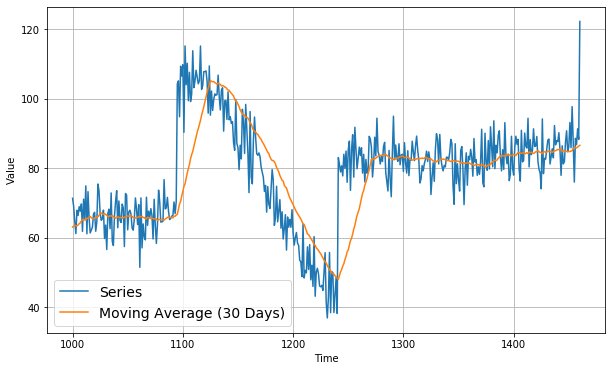

In [15]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, moving_avg, label='Moving Average (30 Days)')

In [16]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

Moving Average was slightly worse than the Naive Forecast. Let's try a different approach!

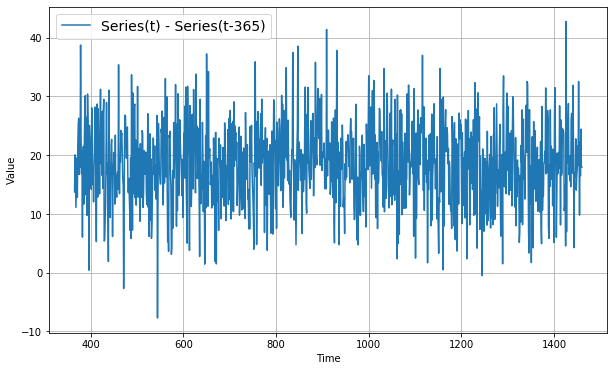

In [17]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label="Series(t) - Series(t-365)")
plt.show()

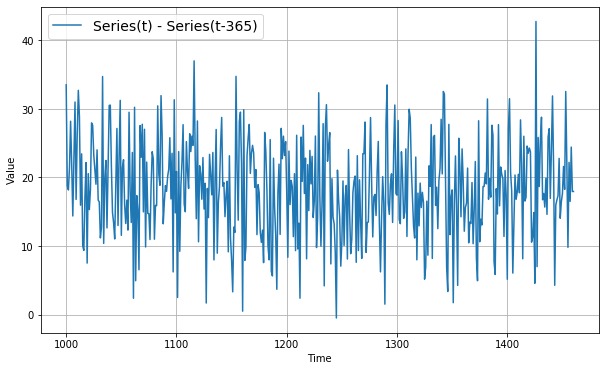

In [18]:
plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time-365:], label='Series(t) - Series(t-365)')
plt.show()

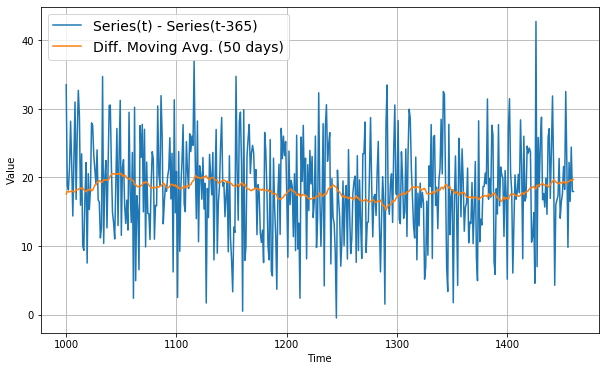

In [20]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time-365:], label='Series(t) - Series(t-365)')
plot_series(time_valid, diff_moving_avg, label='Diff. Moving Avg. (50 days)')
plt.show()

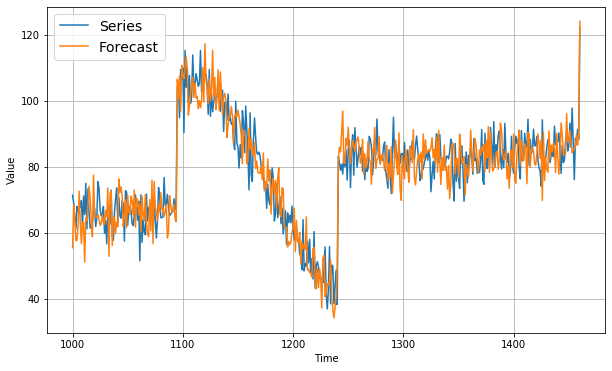

In [21]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecast")
plt.show()

In [22]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.839310562995895

Barely better than the Naive Forecast. Now let's add smoothing!

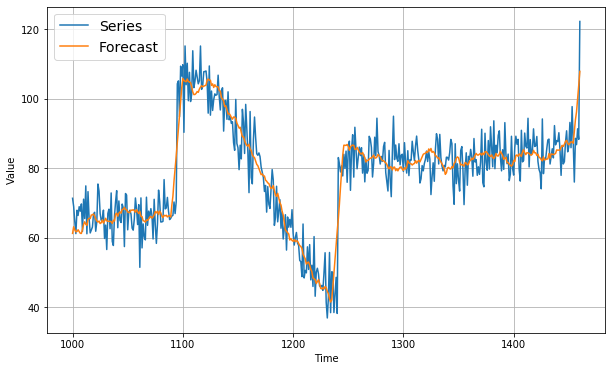

In [23]:
diff_moving_avg_smoothed = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, diff_moving_avg_smoothed, label='Forecast')
plt.show()

In [24]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_smoothed).numpy()

4.566859958970771

Not bad! Now we can get into the more interesting, Machine Learning based stuff. 